In [1]:
import sys
sys.path.append("../") # ugly way to have .py files in the PYTHONPATH

In [2]:
import pandas as pd
import tqdm
import graph_tool.all as gt

from utils import get_config, read_id_table, read_info_files

In [3]:
CONFIG = "../config.yaml"
DIR = ".."

In [4]:
config = get_config(CONFIG, section="alex")
datadir = get_config(CONFIG, section="files")["data_dir"]
info_file = get_config(CONFIG, section="files")["info_filename"]
citation_graph_file = config["citation_graph_file"]
id_table_file = config["id_table"]

df_info = pd.read_csv(f"{DIR}/{datadir}/{info_file}", index_col=0)

In [5]:
edges = []
df_edges = pd.read_csv(f"{DIR}/{datadir}/{citation_graph_file}")
for i, row in df_edges.iterrows():
    edges.append((row["cited paper"], row["citing paper"]))

In [6]:
# prepare nodes
id2alex, alex2id = read_id_table(f"{DIR}/{datadir}/{id_table_file}")

In [7]:
nodes = id2alex.keys()
print(len(nodes))

2189


In [8]:
g = gt.Graph(directed=True)
node_id = g.new_vp("string")
node_number = g.new_vp("int")
id2node = {}

In [9]:
for node in nodes:
     gnode = g.add_vertex()
     node_id[gnode] = node
     id2node[node] = gnode
     node_number[gnode] = df_info[df_info["id"] == node].index.values[0]

In [10]:
for node1, node2 in edges:
    gnode1, gnode2 = id2node[node1], id2node[node2]
    if gnode1 != gnode2:
        g.add_edge(gnode2, gnode1) # edge from citing to cited

In [151]:

node_size = g.new_vp("int")
node_color = g.new_vp("string")
node_shape = g.new_vp("string", val="circle")
node_halo = g.new_vp("bool", val=False)

def is_author(node, author="Hutter"):
    id_ = node_id[node]
    authors = df_info[df_info["id"] == id_]["authors"].values[0]
    return author in authors

for node in g.vertices():
    node_size[node] = node.in_degree()+1
    if is_author(node, author="Vidnerov"):
        node_color[node] = "blue"
        node_halo[node] = True
        print("hola hop")
    elif is_author(node):
        node_color[node] = "red"
    else:
        node_color[node] = "gray"

hola hop


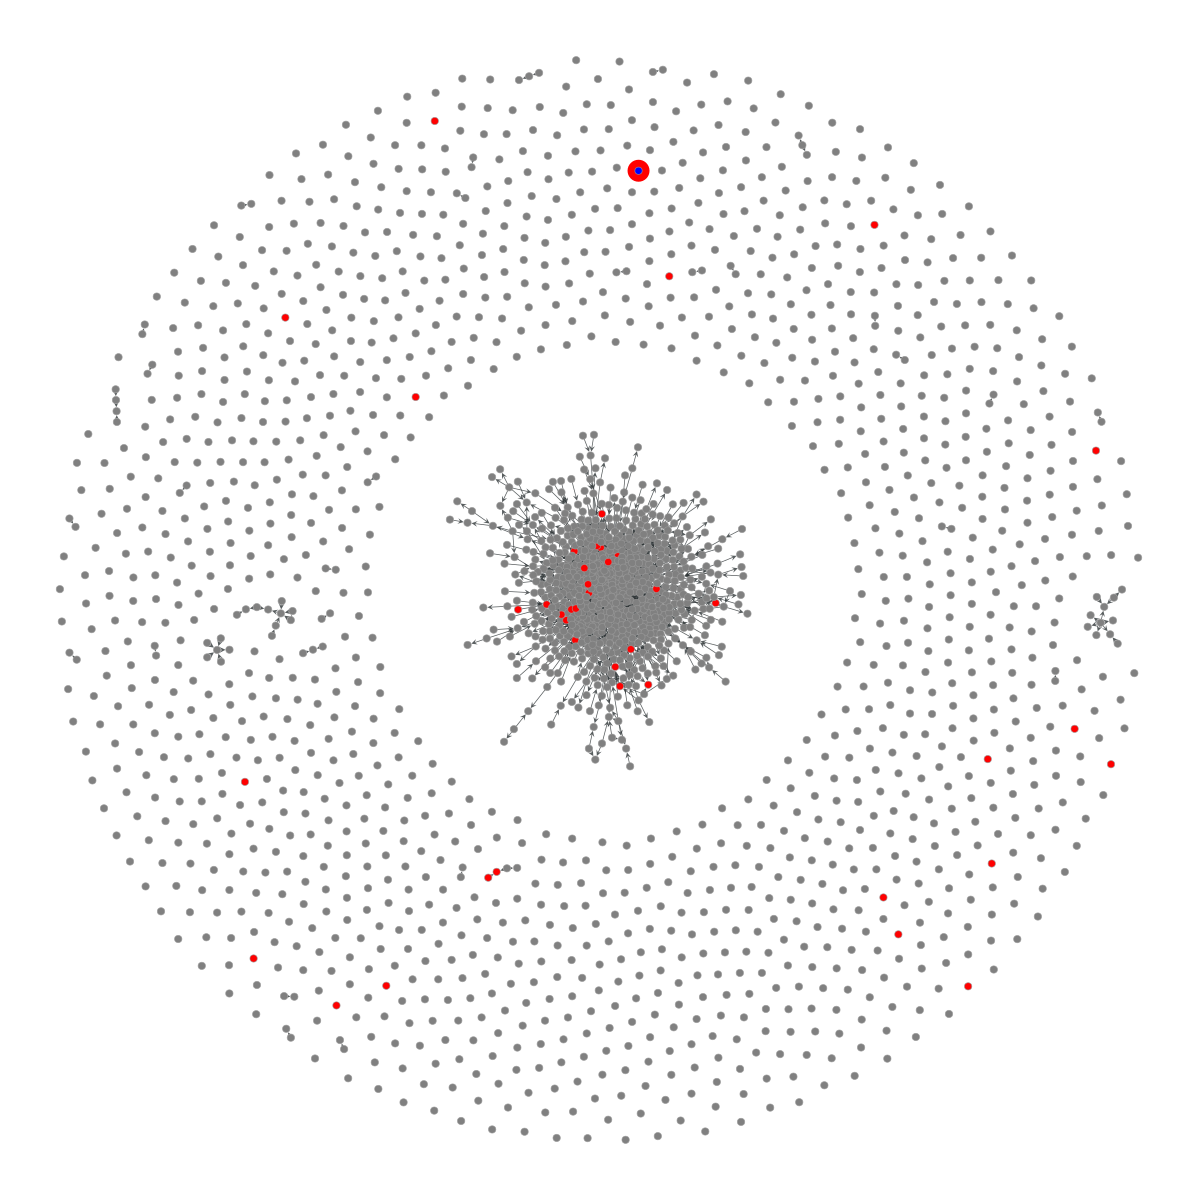

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x75498fac02c0, at 0x75498d734050>

In [152]:
gt.graph_draw(g,vertex_fill_color=node_color, vertex_shape=node_shape, vertex_halo=node_halo, vertex_halo_size=3.0,
             vertex_halo_color="red")

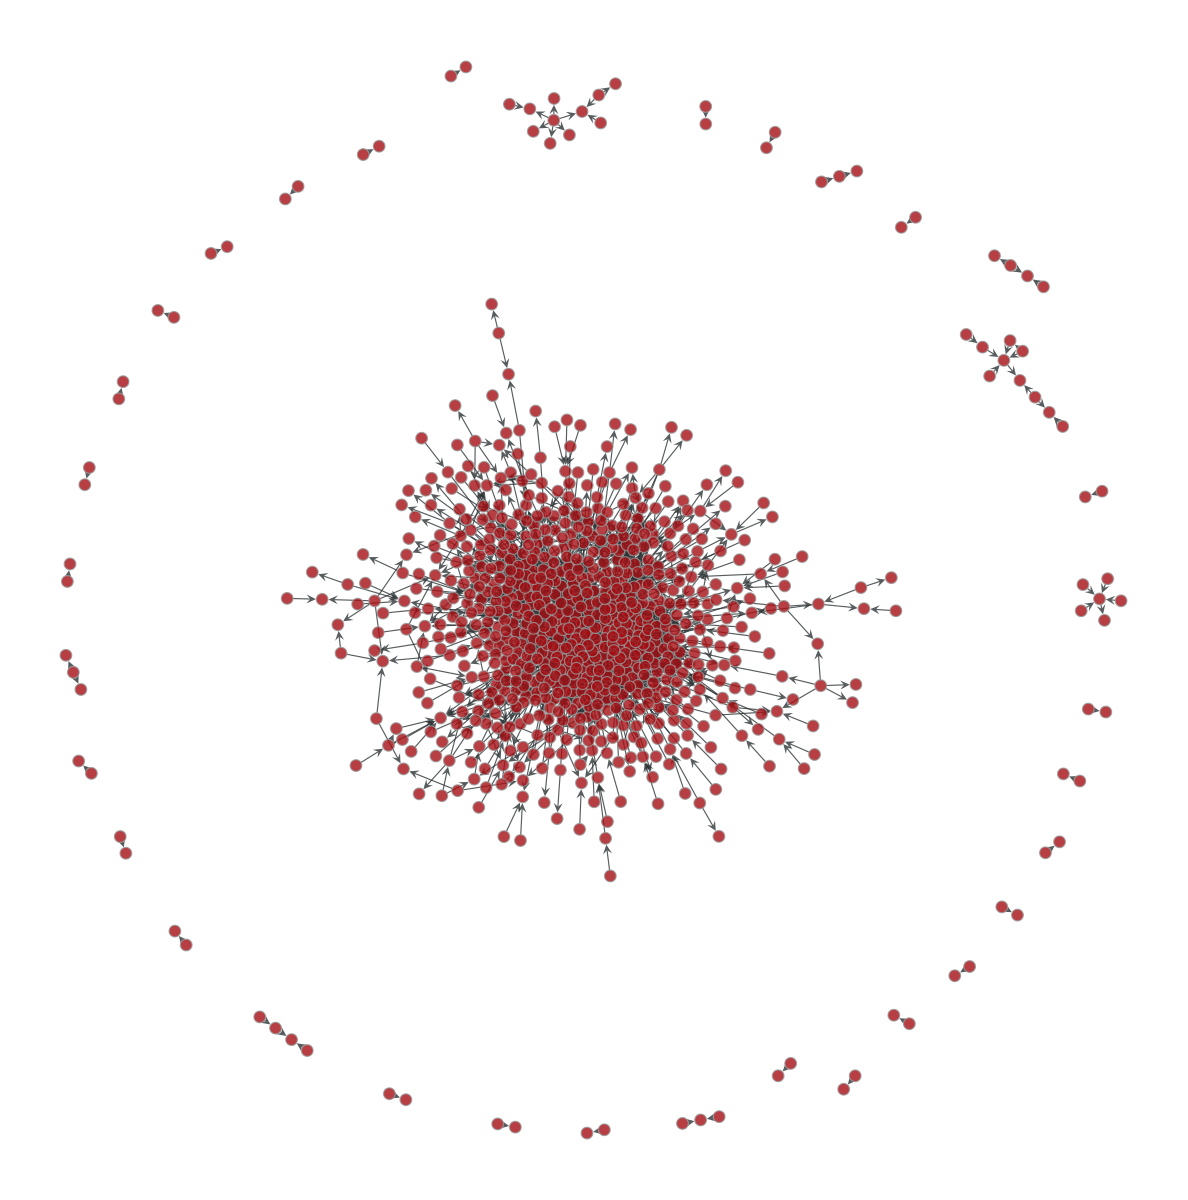

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x754936dd3920, at 0x754936dd0f20>

In [153]:
u = gt.GraphView(g, vfilt=lambda v:  v.in_degree() + v.out_degree() >= 1)
gt.graph_draw(u)

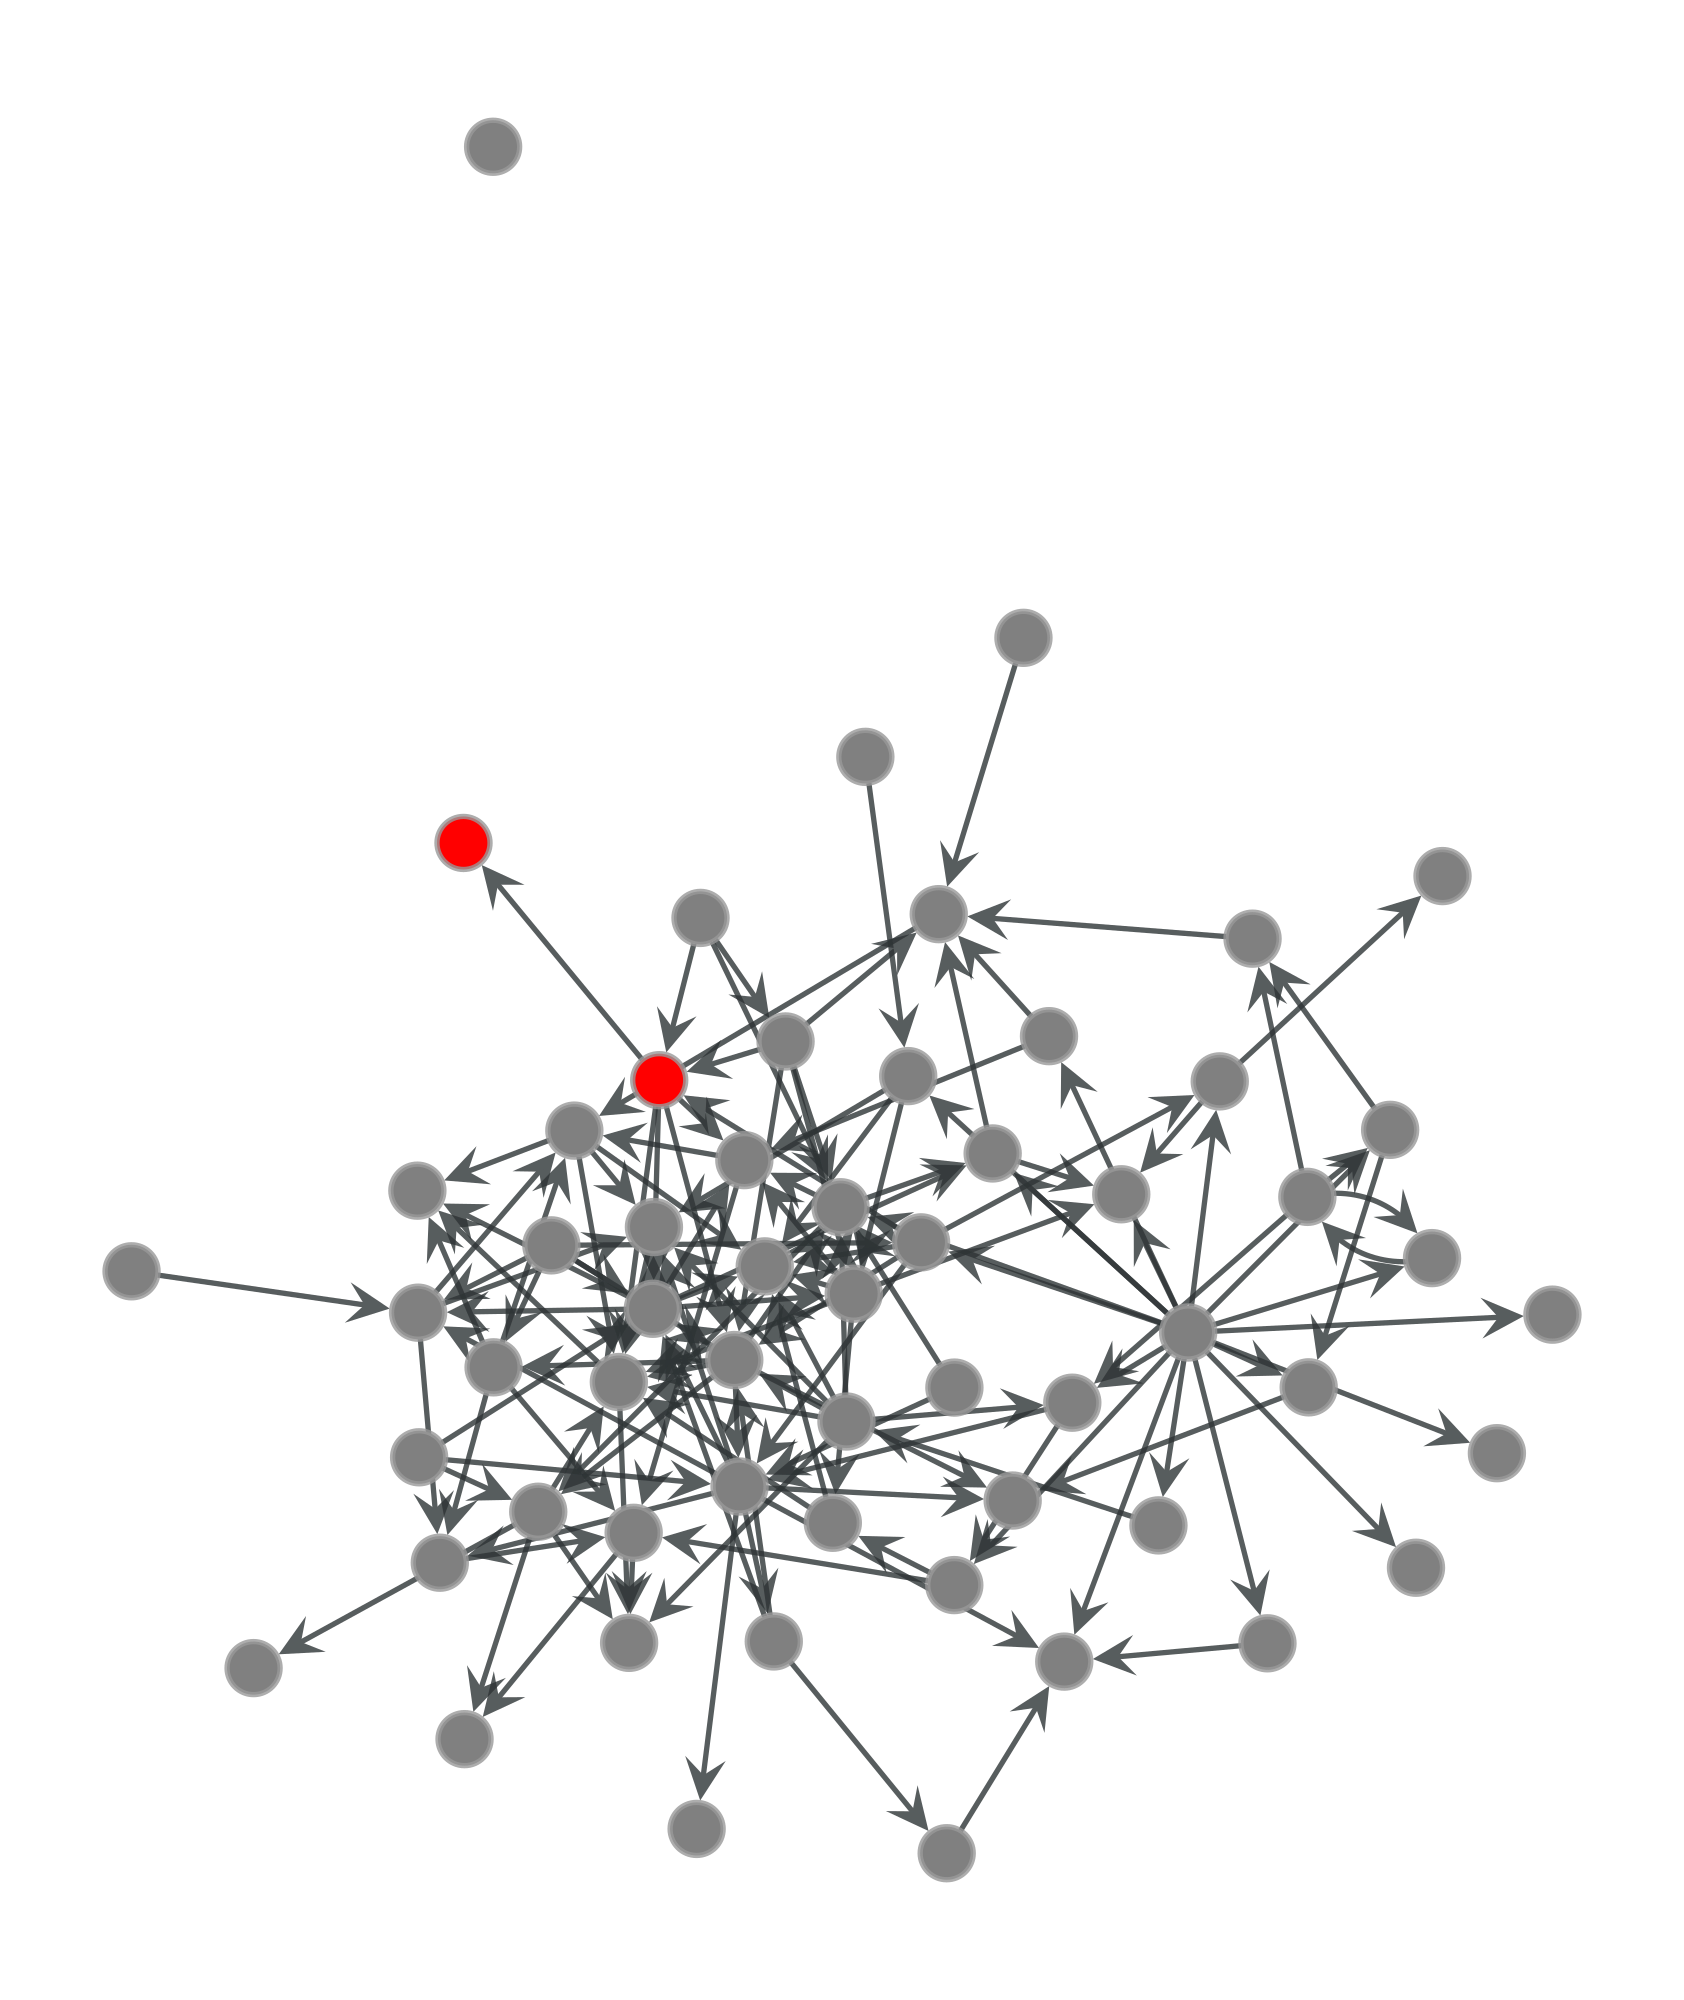

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x75498d51ec60, at 0x75498fc50f80>

In [14]:
v = gt.GraphView(g, vfilt=lambda v:  v.in_degree() >= 10)
gt.graph_draw(v, output_size=(500,1000), vertex_fill_color=node_color)

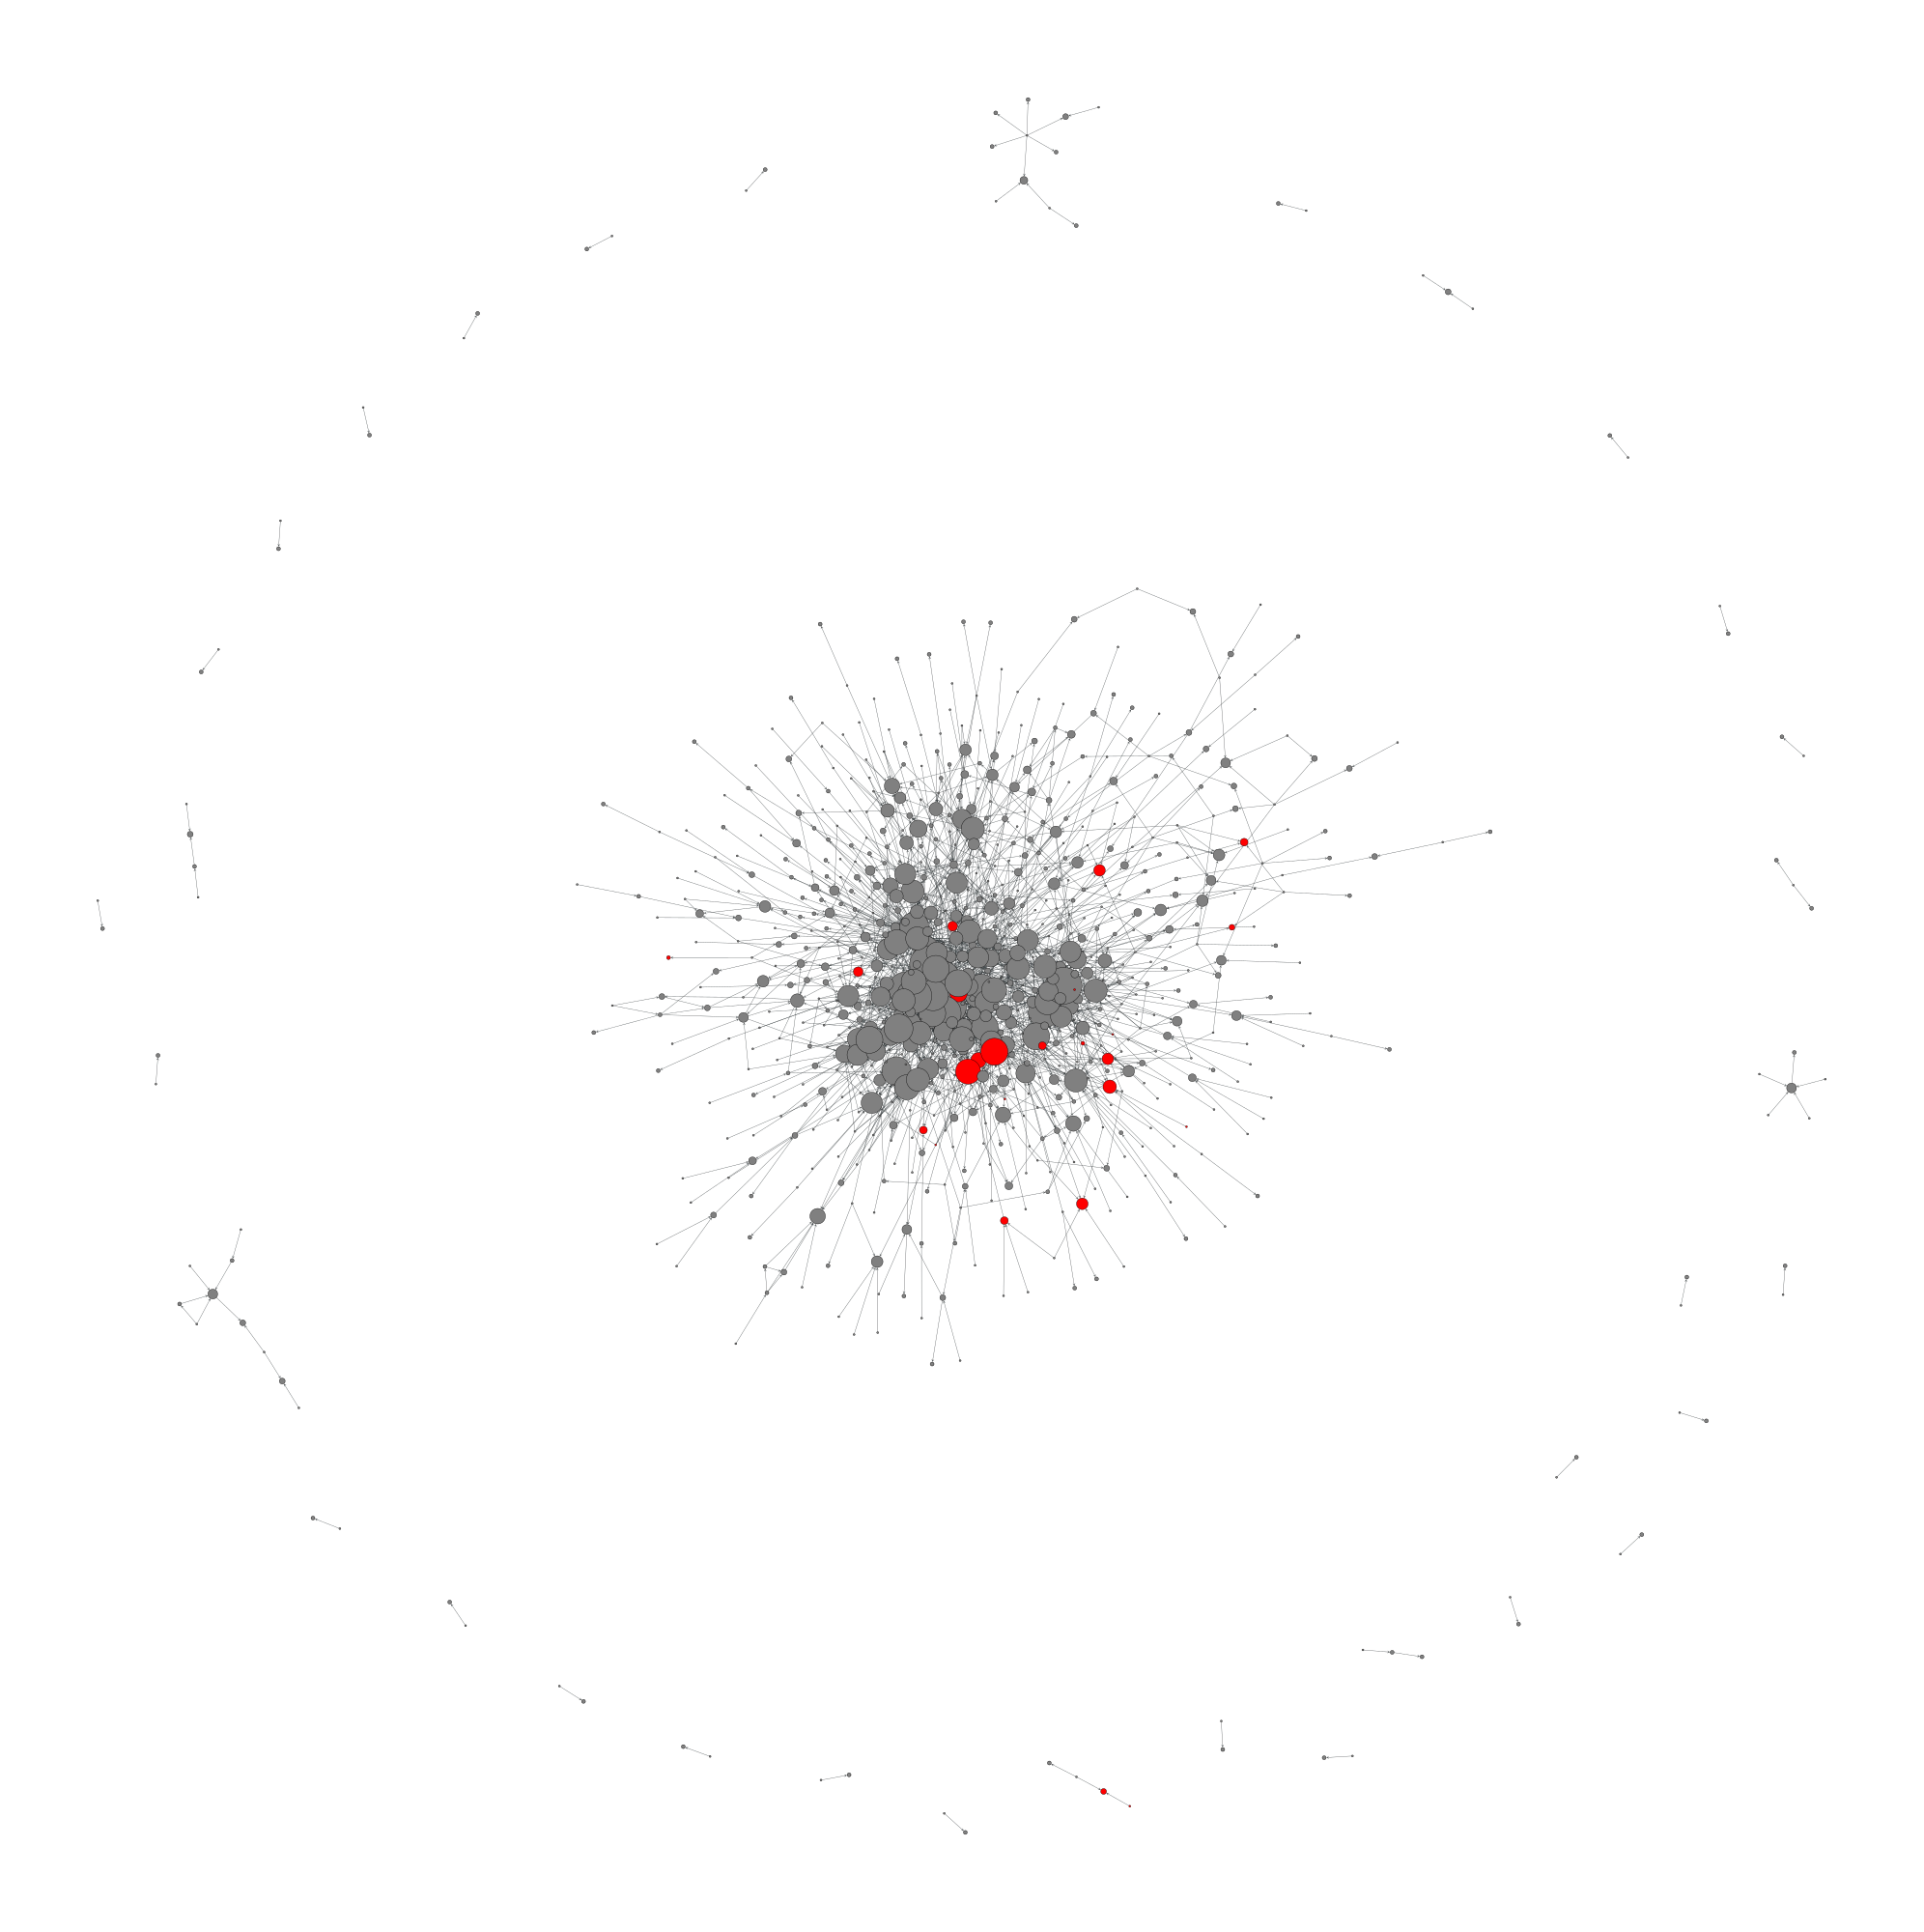

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x75498d51c3e0, at 0x75498d51ca40>

In [15]:
z = gt.GraphView(g, vfilt=lambda v: v.in_degree() + v.out_degree()  > 0)
gt.graph_draw(z, vertex_size=node_size, 
              vertex_color="black", vertex_fill_color=node_color, output_size=(1000, 1000))

In [16]:
df_info[df_info["title"].apply(lambda x: "Surprisingly Strong" in x)]["id"].values[0]

'http://arxiv.org/abs/2404.16551v2'

In [159]:
id2alex["http://arxiv.org/abs/2404.16551v2"] #in id2alex

'https://openalex.org/W4395687037'

In [18]:
from download_references import get_openalex_id_from_arxiv

get_openalex_id_from_arxiv("http://arxiv.org/abs/2404.16551v2")


'https://openalex.org/W4395687037'

In [19]:
sorted_nodes = sorted(g.vertices(), key=lambda v: v.in_degree(), reverse=True)

In [20]:
for i in range(20):
    id_ = node_id[sorted_nodes[i]]
    title = df_info[df_info["id"] == id_]["title"].values[0]
    authors = df_info[df_info["id"] == id_]["authors"].values[0]
    print(authors, ":", title)
        

Sirui Xie;Hehui Zheng;Chunxiao Liu;Liang Lin : SNAS: Stochastic Neural Architecture Search
Han Cai;Ligeng Zhu;Song Han : ProxylessNAS: Direct Neural Architecture Search on Target Task and
  Hardware
Xuanyi Dong;Yi Yang : NAS-Bench-201: Extending the Scope of Reproducible Neural Architecture
  Search
Jieru Mei;Yingwei Li;Xiaochen Lian;Xiaojie Jin;Linjie Yang;Alan Yuille;Jianchao Yang : AtomNAS: Fine-Grained End-to-End Neural Architecture Search
Liam Li;Ameet Talwalkar : Random Search and Reproducibility for Neural Architecture Search
Andrew Brock;Theodore Lim;J. M. Ritchie;Nick Weston : SMASH: One-Shot Model Architecture Search through HyperNetworks
Hieu Pham;Melody Y. Guan;Barret Zoph;Quoc V. Le;Jeff Dean : Efficient Neural Architecture Search via Parameter Sharing
Han Cai;Tianyao Chen;Weinan Zhang;Yong Yu;Jun Wang : Efficient Architecture Search by Network Transformation
Shen Yan;Yu Zheng;Wei Ao;Xiao Zeng;Mi Zhang : Does Unsupervised Architecture Representation Learning Help Neural
  

In [21]:
all_authors=set()
for i, row in df_info.iterrows():
    authors = row["authors"].strip().split(";")
    all_authors.update(authors)
len(all_authors)

7098

In [22]:
number_of_papers = dict()
for author in all_authors:
    number_of_papers[author] = df_info["authors"].apply(lambda x: author in x).sum()
sorted_authors = sorted(all_authors, key=lambda x: number_of_papers[x], reverse=True)

In [23]:
for i in range(200):
    author = sorted_authors[i]
    print(i, author, number_of_papers[author])


0 Frank Hutter 43
1 Yanan Sun 27
2 Alexander Wong 26
3 Yiyu Shi 23
4 Zhenguo Li 22
5 Yiran Chen 19
6 Qi Tian 19
7 Quoc V. Le 19
8 Quanming Yao 18
9 Mingxing Tan 17
10 Mohammad Javad Shafiee 17
11 Weiwen Jiang 17
12 Arber Zela 16
13 Bo Zhang 16
14 Zhangyang Wang 15
15 Xiaodan Liang 15
16 Bing Xu 14
17 Song Han 14
18 Xiangxiang Chu 14
19 Hang Xu 14
20 Hai Li 14
21 Binxin Ru 13
22 Junjie Yan 13
23 Pengtao Xie 13
24 Wanli Ouyan 13
25 Yunhe Wang 13
26 Feng Yan 13
27 Lingxi Xie 13
28 Yu Li 13
29 Chang Xu 13
30 Xin Wang 12
31 Bing Xue 12
32 Luca Benini 12
33 Yuandong Tian 12
34 Chen Qian 12
35 Xin Chen 12
36 Rongrong Ji 12
37 Wanli Ouyang 12
38 Zhichao Lu 12
39 Meng Li 12
40 Mengjie Zhang 12
41 Hanxiao Liu 12
42 Shoukang Hu 12
43 Xiaojun Chang 12
44 Xiaoliang Dai 12
45 Xunying Liu 11
46 Tunhou Zhang 11
47 Daniele Jahier Pagliari 11
48 Huan Zhao 11
49 Yang Li 11
50 Prasanna Balaprakash 11
51 Alessio Burrello 11
52 Xinyu Gong 11
53 Thomas Elsken 11
54 Wenwu Zhu 10
55 Lei Yang 10
56 Matteo Risso

In [24]:
number_of_citations = dict()
for author in tqdm.tqdm(all_authors):
    paper_ids = df_info[df_info["authors"].apply(lambda x: author in x)]["id"]
    citations = []
    for pid in paper_ids:
        node = id2node.get(pid, None)
        if node is None:
            continue
        citations.append(node.in_degree())
    number_of_citations[author] = sum(citations)


    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7098/7098 [00:03<00:00, 2057.88it/s]


In [25]:
sorted_authors = sorted(all_authors, key=lambda x: number_of_citations.get(x, 0), reverse=True)

In [26]:
for i in range(300):
    author = sorted_authors[i]
    print(i, author, number_of_citations[author])


0 Frank Hutter 92
1 Qi Tian 72
2 Han Cai 69
3 Yuandong Tian 63
4 Xin Chen 58
5 Zhenguo Li 57
6 Hanxiao Liu 57
7 Song Han 56
8 Lingxi Xie 56
9 Xiangxiang Chu 52
10 Bo Zhang 51
11 Alan Yuille 47
12 Barret Zoph 47
13 Yunhe Wang 46
14 Quoc V. Le 46
15 Thomas Elsken 44
16 Arber Zela 43
17 Yong Yu 43
18 Weinan Zhang 43
19 Bichen Wu 40
20 Qian Zhang 40
21 Peizhao Zhang 39
22 Xiaoliang Dai 39
23 Peter Vajda 38
24 Junjie Yan 37
25 Pieter-Jan Kindermans 37
26 Gabriel Bender 37
27 Yuhui Xu 36
28 Mingxing Tan 36
29 Xiaopeng Zhang 34
30 Gaofeng Meng 33
31 Chang Xu 33
32 Xuanyi Dong 32
33 Weiwen Jiang 32
34 Xiangyu Zhang 31
35 Jun Wang 31
36 Jian Sun 31
37 Ruijun Xu 31
38 Jun Wan 31
39 Sirui Xie 31
40 Yukang Chen 30
41 Jiashi Feng 30
42 Chunxiao Liu 29
43 Hehui Zheng 29
44 Chenxi Liu 29
45 Wei Wei 29
46 Renqian Luo 28
47 Wei Wu 28
48 Xiaojie Jin 28
49 Rodrigo Fonseca 28
50 Tao Qin 28
51 Quoc Le 28
52 Linnan Wang 28
53 Kaicheng Yu 28
54 Zhangyang Wang 27
55 Yiyu Shi 27
56 Xinyu Gong 27
57 Da-Cheng Ju

In [215]:
only_connected = gt.GraphView(g, vfilt=lambda x: x.in_degree() + x.out_degree() > 0)
state = gt.minimize_blockmodel_dl(only_connected)

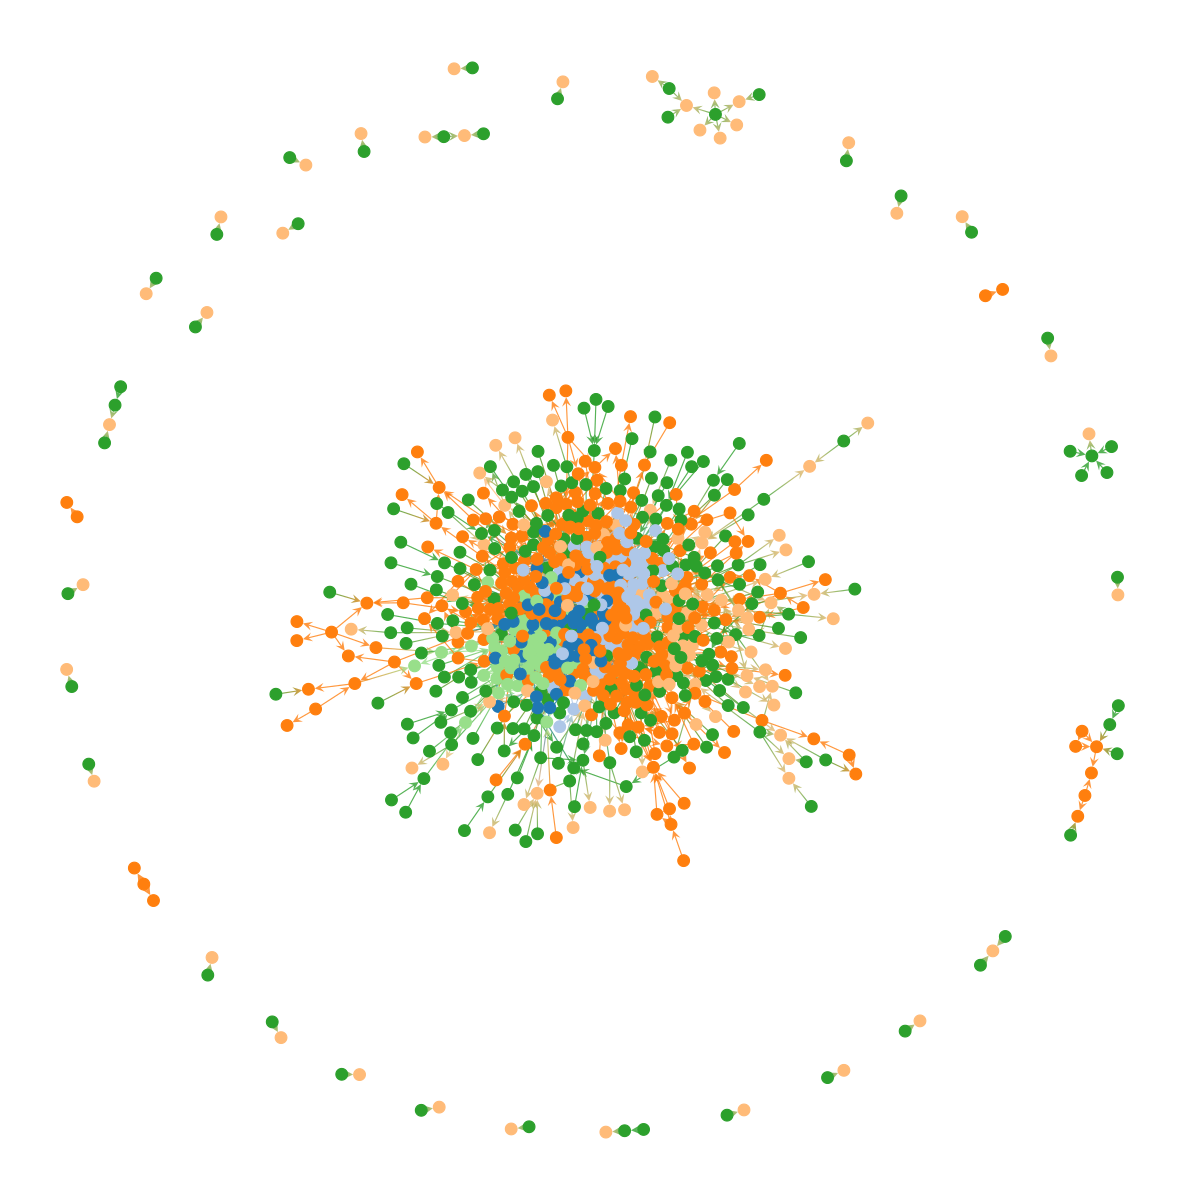

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x75493bf2dd60, at 0x75493bf43da0>

In [216]:
state.draw()

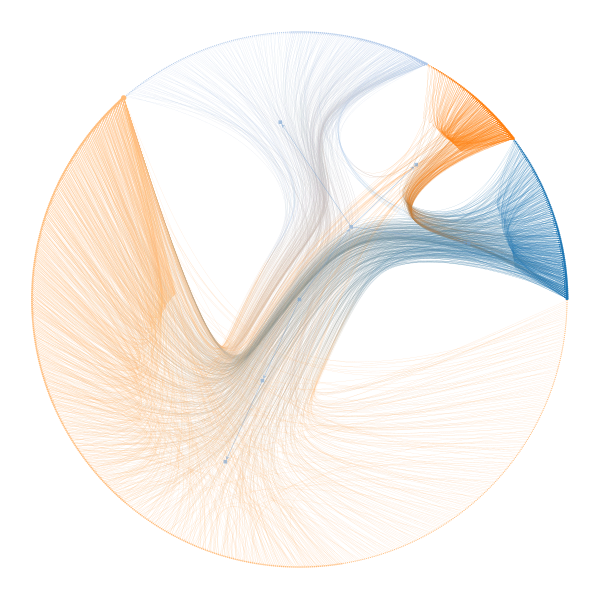

<NestedBlockState object, with base <BlockState object with 861 blocks (4 nonempty), degree-corrected, for graph <GraphView object, directed, with 861 vertices and 1804 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x75493bf2dd60, at 0x75493bf41ac0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x75493bf2dd60, at 0x75493bf43e60>, False), at 0x75493bf2dd60>, at 0x75493bec3c20>, and 11 levels of sizes [(861, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x75493bf41010>

In [226]:
state = gt.minimize_nested_blockmodel_dl(only_connected)
state.draw(output_size=(300,300))
state

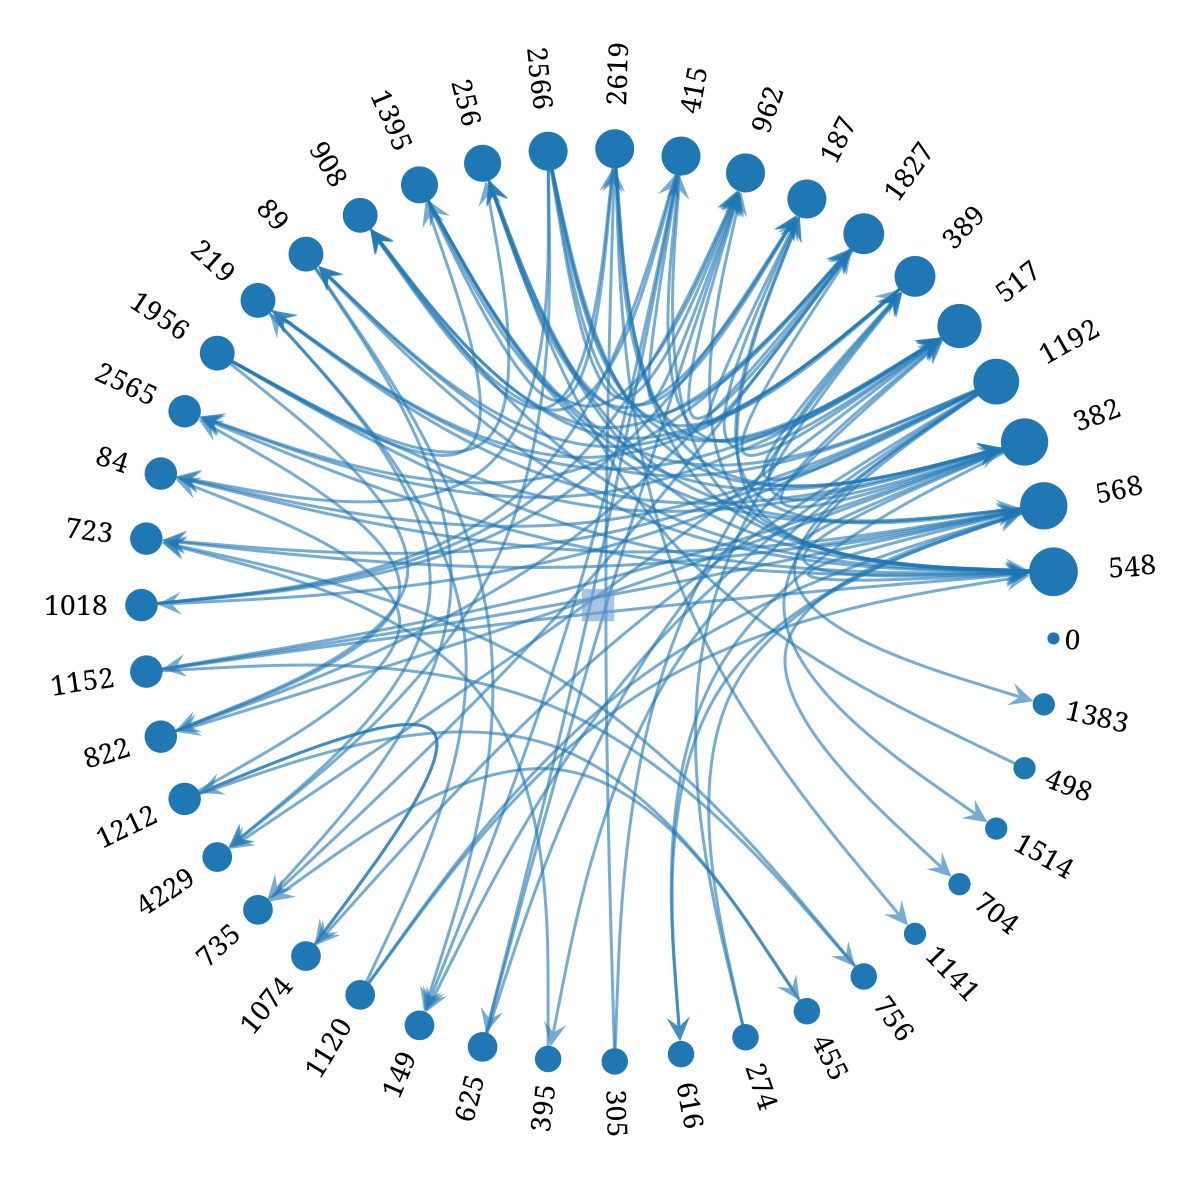

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x754936e0b410, at 0x75498d745af0>,
 <GraphView object, directed, with 44 vertices and 43 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x754936e153d0, at 0x75493bf8fa10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x754936e153d0, at 0x75493bf8e390>, False), at 0x754936e153d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x754936e153d0, at 0x75493bf9c530>)

In [218]:
u = gt.GraphView(g, vfilt=lambda x: x.in_degree() > 10)
state = gt.minimize_nested_blockmodel_dl(u)
state.draw(vertex_text=node_number, vertex_text_position="centered", vertex_font_size=14)

In [31]:
KEY = 610
print(df_info.loc[KEY]["title"])
print(df_info.loc[KEY]["authors"])

A Comprehensive Survey on Hardware-Aware Neural Architecture Search
Hadjer Benmeziane;Kaoutar El Maghraoui;Hamza Ouarnoughi;Smail Niar;Martin Wistuba;Naigang Wang


In [32]:
for i, row in df_info[df_info["title"].apply(lambda x: "survey" in x.lower())].iterrows():
    print(i, row["title"])

21 From Federated Learning to Federated Neural Architecture Search: A
  Survey
179 A Survey on Neural Architecture Search Based on Reinforcement Learning
239 A Survey on Neural Architecture Search
465 Neural Architecture Search: A Survey
505 Combining Neural Architecture Search and Automatic Code Optimization: A
  Survey
610 A Comprehensive Survey on Hardware-Aware Neural Architecture Search
647 A Comprehensive Survey of Neural Architecture Search: Challenges and
  Solutions
694 A Survey on Evolutionary Neural Architecture Search
757 A Survey of Supernet Optimization and its Applications: Spatial and
  Temporal Optimization for Neural Architecture Search
973 A Survey on Computationally Efficient Neural Architecture Search
982 Efficient Automation of Neural Network Design: A Survey on
  Differentiable Neural Architecture Search
1048 A Survey on Multi-Objective Neural Architecture Search
1430 Efficient Evaluation Methods for Neural Architecture Search: A Survey
1717 Evolutionary Algorith

# TOPIC SELECTION

In [193]:
COLLECTION = "differentiable optimisation"
HIGHLIGHT = "differentiable optimisation"

In [194]:
df_keywords = pd.read_csv("../data/keywords_info.csv", index_col=0).set_index("id") == "YES"

In [195]:
df_keywords.columns

Index(['reinforcement learning', 'evolutionary algorithms',
       'bayesian optimisation', 'multi-objective optimisation', 'supernet',
       'weight sharing', 'differentiable optimisation',
       'zero cost proxies or training free', 'hardware aware search',
       'surrogate models'],
      dtype='object')

In [196]:
vertex_category = g.new_vp("string", val="blue")
for i, row in df_keywords[df_keywords[HIGHLIGHT]].iterrows():
    n = id2node.get(i, None)
    if n is None:
        continue
    vertex_category[n] = "red"

In [197]:
id2node

{'http://arxiv.org/abs/2006.06936v2': <Vertex object with index '0' at 0x75498f9e91c0>,
 'http://arxiv.org/abs/2009.13266v1': <Vertex object with index '1' at 0x754a5c0913c0>,
 'http://arxiv.org/abs/2203.01559v1': <Vertex object with index '2' at 0x75498f9e94c0>,
 'http://arxiv.org/abs/2210.17180v2': <Vertex object with index '3' at 0x75498f9e9540>,
 'http://arxiv.org/abs/2112.07805v1': <Vertex object with index '4' at 0x75498f9e95c0>,
 'http://arxiv.org/abs/2105.13258v1': <Vertex object with index '5' at 0x75498f9e9640>,
 'http://arxiv.org/abs/2305.05351v4': <Vertex object with index '6' at 0x75498f9e96c0>,
 'http://arxiv.org/abs/1808.00391v1': <Vertex object with index '7' at 0x75498f9e9740>,
 'http://arxiv.org/abs/1812.05866v2': <Vertex object with index '8' at 0x75498f9e9840>,
 'http://arxiv.org/abs/2409.14432v2': <Vertex object with index '9' at 0x75498f9e9940>,
 'http://arxiv.org/abs/2003.01335v1': <Vertex object with index '10' at 0x75498f9e99c0>,
 'http://arxiv.org/abs/2207.103

In [198]:
selection = gt.GraphView(g, vfilt=lambda x: df_keywords.loc[node_id[x], COLLECTION] == True)
selection2 = gt.GraphView(selection, vfilt=lambda x: x.in_degree() > 0)

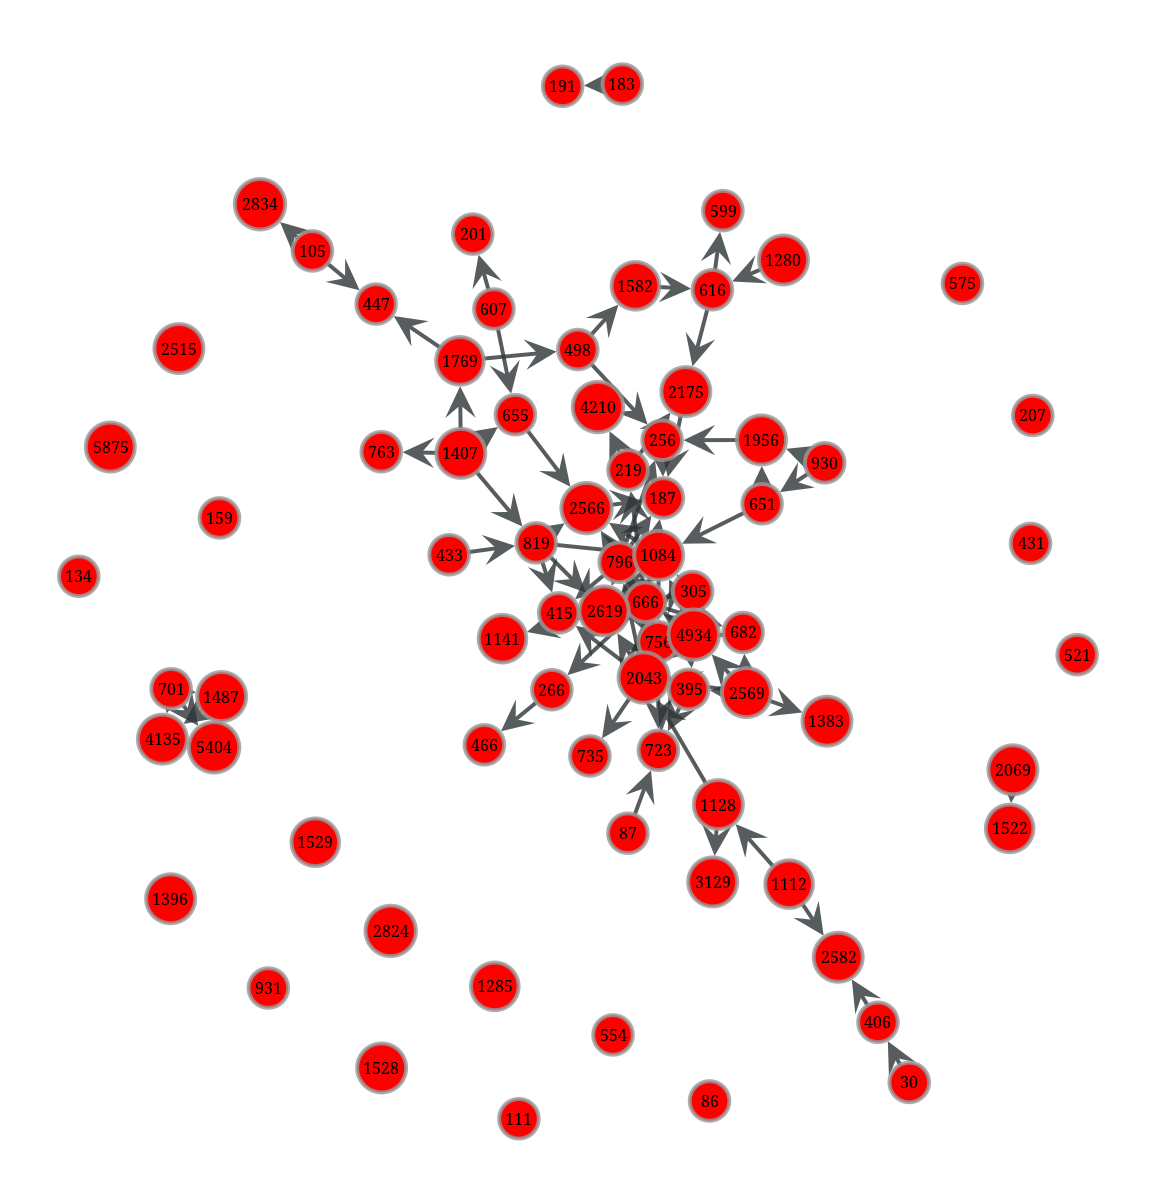

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x754945fb98b0, at 0x754936dd1ca0>

In [199]:
gt.graph_draw(selection2, vertex_fill_color=vertex_category, vertex_text=node_number, vertex_text_position=-1,
             vertex_text_color="black", vertex_font_size=8)

In [200]:
print(df_info.loc[305].title)
print(df_info.loc[305].authors)



Rethinking Architecture Selection in Differentiable NAS
Ruochen Wang;Minhao Cheng;Xiangning Chen;Xiaocheng Tang;Cho-Jui Hsieh


In [201]:
node_author = g.new_vp("string", val="blue")
for i, row in df_info.iterrows():
    if "Sekanina" in row["authors"]:
        n = id2node.get(row["id"], None)
        if n is None:
            continue
        node_author[n] = "red"

In [202]:
id2node

{'http://arxiv.org/abs/2006.06936v2': <Vertex object with index '0' at 0x75498f9e91c0>,
 'http://arxiv.org/abs/2009.13266v1': <Vertex object with index '1' at 0x754a5c0913c0>,
 'http://arxiv.org/abs/2203.01559v1': <Vertex object with index '2' at 0x75498f9e94c0>,
 'http://arxiv.org/abs/2210.17180v2': <Vertex object with index '3' at 0x75498f9e9540>,
 'http://arxiv.org/abs/2112.07805v1': <Vertex object with index '4' at 0x75498f9e95c0>,
 'http://arxiv.org/abs/2105.13258v1': <Vertex object with index '5' at 0x75498f9e9640>,
 'http://arxiv.org/abs/2305.05351v4': <Vertex object with index '6' at 0x75498f9e96c0>,
 'http://arxiv.org/abs/1808.00391v1': <Vertex object with index '7' at 0x75498f9e9740>,
 'http://arxiv.org/abs/1812.05866v2': <Vertex object with index '8' at 0x75498f9e9840>,
 'http://arxiv.org/abs/2409.14432v2': <Vertex object with index '9' at 0x75498f9e9940>,
 'http://arxiv.org/abs/2003.01335v1': <Vertex object with index '10' at 0x75498f9e99c0>,
 'http://arxiv.org/abs/2207.103

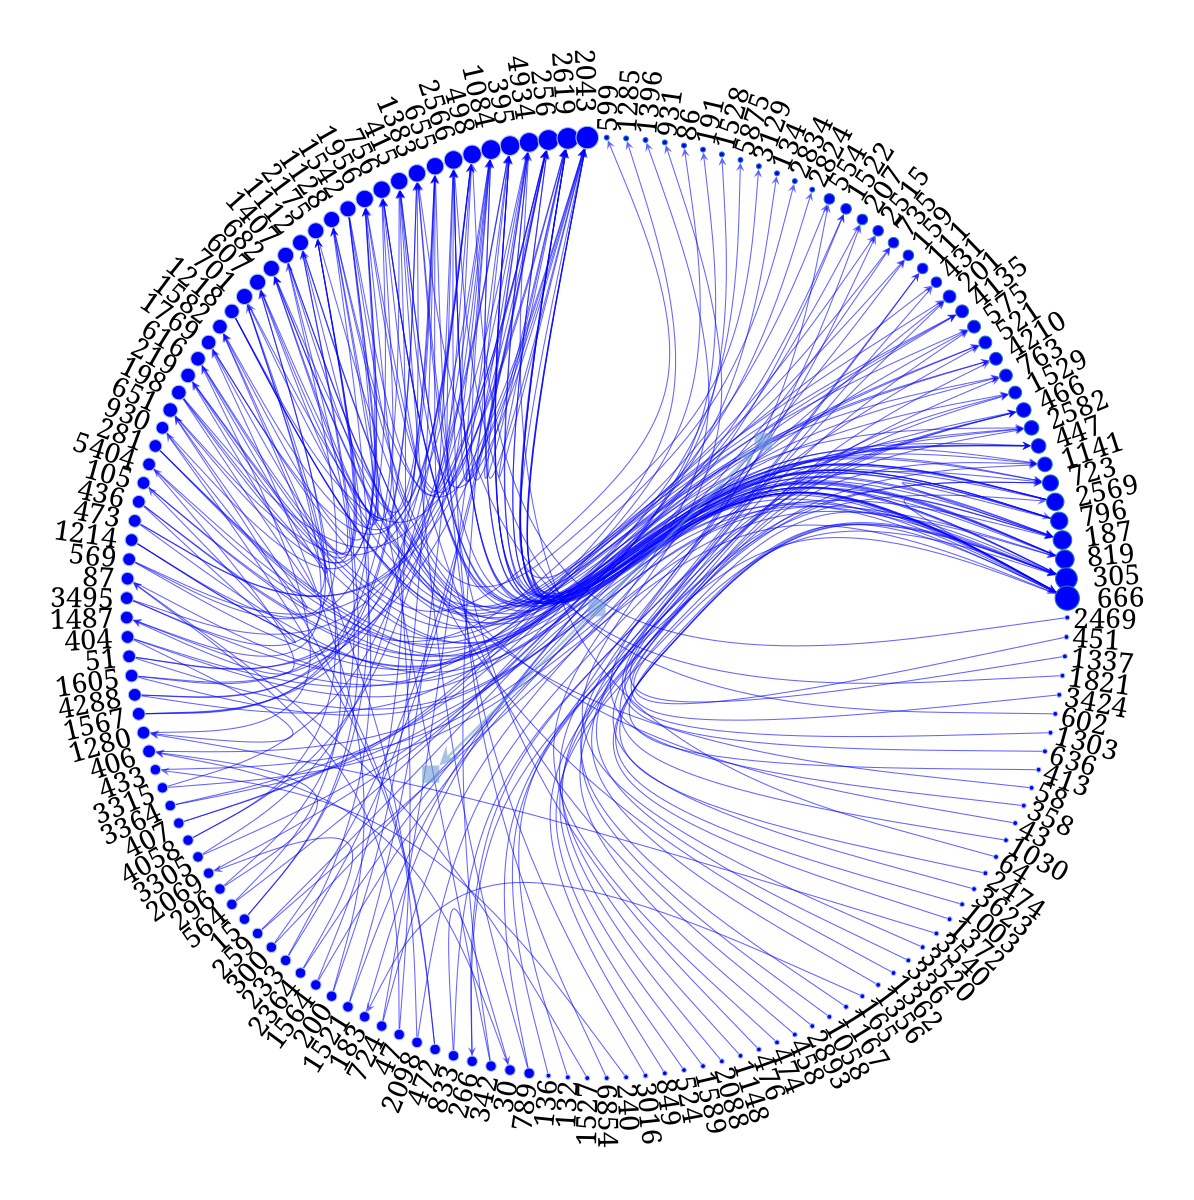

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x754936ca3da0, at 0x754936d41130>,
 <GraphView object, directed, with 155 vertices and 154 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x754936dd38f0, at 0x754936d70530>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x754936dd38f0, at 0x754936d704d0>, False), at 0x754936dd38f0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x754936dd38f0, at 0x754936d43920>)

In [203]:
selection3 = gt.GraphView(selection, vfilt=lambda x: x.in_degree() + x.out_degree() > 0)  
state = gt.minimize_nested_blockmodel_dl(selection3)
state.draw(vertex_text=node_number, vertex_text_position="centered", vertex_font_size=14,
          vertex_fill_color=node_author)